#  Importing libraries 

In [1]:
import pandas as pd 
import numpy as np 
import os 

C:\Users\Hassan Kerroumi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
for dirname, _, filenames in os.walk('Garbage_Classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Garbage_Classification\one-indexed-files-notrash_test.txt
Garbage_Classification\one-indexed-files-notrash_train.txt
Garbage_Classification\one-indexed-files-notrash_val.txt
Garbage_Classification\one-indexed-files.txt
Garbage_Classification\zero-indexed-files.txt
Garbage_Classification\Garbage classification\cardboard\cardboard1.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard10.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard100.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard101.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard102.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard103.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard104.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard105.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard106.jpg
Garbage_Classification\Garbage classification\cardboard\cardboard107.jpg
Garbage_

In [3]:
# reading and processing data 
import cv2
import urllib 
import itertools 
import seaborn as sns 
import os, random, glob
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen 

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

# model evaluation 
from sklearn.metrics import confusion_matrix, classification_report 

# modeling 

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.regularizers import l2

#  Reading the dataset 

In [4]:
target_size = (224, 224)
waste_labels = { 'glass':0, 'metal':1, 'paper':2, 'plastic':3, 'trash':4}

In [5]:
def load_dataset(path):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(waste_labels[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return np.array(x), np.array(labels) 


In [6]:
train_dir_path = 'Garbage_Classification_splited/Train'
val_dir_path = 'Garbage_Classification_splited/Val'
test_dir_path = 'Garbage_Classification_splited/Test'

In [7]:
xtrain, ytrain = load_dataset(train_dir_path)
xtrain = xtrain / 255.0 
xtrain.shape

X size : (1584, 224, 224, 3)
Number of label classes [0 1 2 3 4], Number of observation in the dataset : 1584


(1584, 224, 224, 3)

In [8]:
xval, yval = load_dataset(val_dir_path)
xval = xval / 255.0
xval.shape

X size : (270, 224, 224, 3)
Number of label classes [0 1 2 3 4], Number of observation in the dataset : 270


(270, 224, 224, 3)

In [9]:
xtest, ytest = load_dataset(test_dir_path)
xtest = xtest / 255.0
xtest.shape

X size : (270, 224, 224, 3)
Number of label classes [0 1 2 3 4], Number of observation in the dataset : 270


(270, 224, 224, 3)

In [10]:
input_shape = (np.array(xtrain[0]).shape[1], np.array(xtrain[0]).shape[0], 3)
print(input_shape)

(224, 224, 3)


In [11]:
np.array(list(list(waste_labels.keys())))

array(['glass', 'metal', 'paper', 'plastic', 'trash'], dtype='<U7')

# Sample from dataset

In [14]:
def visualize_img(image_batch, label_batch,n):
    """  Parameters:



  image_batch: Storing the matrix information of the images



  label_batch: A list that stores the class information of the image

    """
    plt.figure(figsize=(15,65))
    j = 0
    for n in range(100+n):
        ax = plt.subplot(20,5,j+1)
        j +=1
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys())) [to_categorical(ytrain, num_classes=5)[n]==1][0].title())

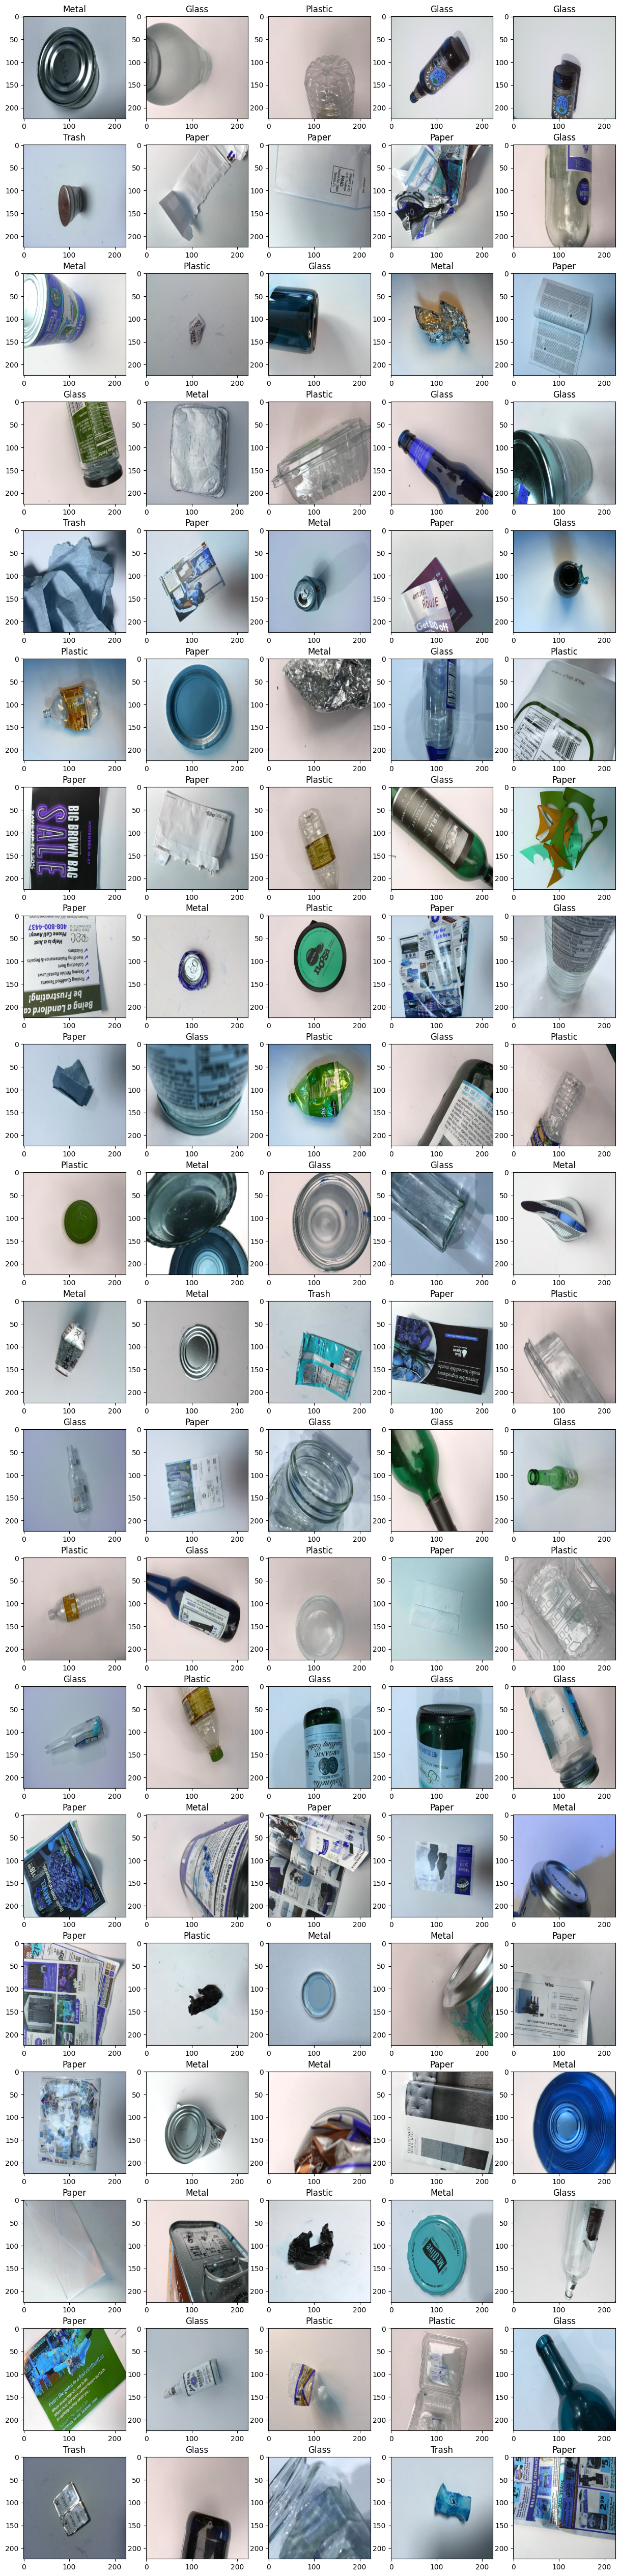

In [15]:
visualize_img(xtrain, ytrain,0)

# Modeling
- Create a CNN model 

In [16]:
model = Sequential([
    # Layer 1
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', 
           activation='relu', input_shape=input_shape),  
    MaxPooling2D(pool_size=(2, 2)),
    
    # Layer 2
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),                                                          
    # Layer 3 
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),                                                          
    # Layer 4
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    # Layer 5
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    # Layer 6
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten and Fully Connected Layers
    Flatten(),                                                                             
    Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(units=6, activation='softmax'), 
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 691,142 (2.64 MB)

 Trainable params: 691,142 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the model 

In [18]:
callbacks = [EarlyStopping(monitor='val_loss',

                           patience=50,

                           verbose=1,

                           mode="min"),



             ModelCheckpoint(filepath='Model_7.keras',

                             monitor='val_loss',
                             mode='min',

                             save_best_only=True,

                             save_weights_only=False,

                             verbose=1)]

In [19]:
model.compile(optimizer = 'adam', loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(xtrain, ytrain, epochs = 50,callbacks = callbacks,  validation_data = (xval, yval))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2824 - loss: 3.4547
Epoch 1: val_loss improved from inf to 2.63533, saving model to Model_7.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.2824 - loss: 3.4485 - val_accuracy: 0.2222 - val_loss: 2.6353
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2797 - loss: 2.4290
Epoch 2: val_loss improved from 2.63533 to 2.12522, saving model to Model_7.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.2798 - loss: 2.4262 - val_accuracy: 0.2222 - val_loss: 2.1252
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3217 - loss: 1.9414
Epoch 3: val_loss improved from 2.12522 to 1.90000, saving model to Model_7.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.3213 - loss: 1.9407 - val_accuracy: 0.2222 - val_loss: 1.9000
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2847 - loss: 1.7922
Epoch 4: val_loss improved from 1.90000 to 1.79163, saving model to Model_7.ke

# Testing

In [35]:
pred = model.predict(xtest)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step


# Evaluation 

11/11 - 7s - 602ms/step - accuracy: 0.5515 - loss: 2.1964


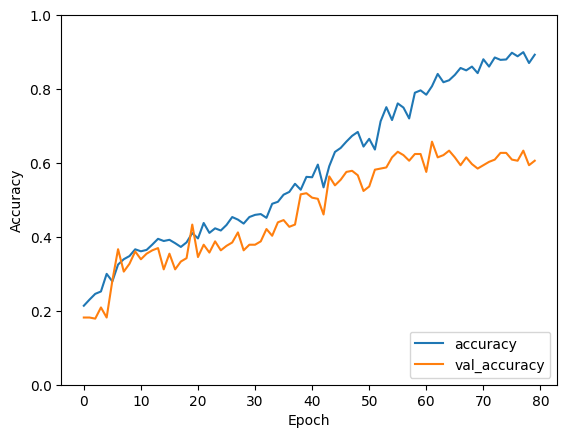

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)

# Deployment

# Work with a CNN pre-trained model to extract features 

In [213]:
from tensorflow.keras.applications import  ResNet

In [214]:
preTrainedModel = ResNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
preTrainedModel.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Get features from the model

In [215]:
Xtrain_features = preTrainedModel.predict(xtrain)
Xtest_features = preTrainedModel.predict(xtest)
xval_features = preTrainedModel.predict(xval)

56/56 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step


In [218]:
Xtrain_features.shape

(1768, 7, 7, 512)

In [163]:
NN_model = Sequential([
    Input(shape=(2048,)),
    Dense(units = 1020, activation = "relu"),
    Dense(units = 500, activation = "relu"),
    Dense(units = 128, activation = "relu"),
    Dense(units = 10, activation = "softmax"),

])

In [164]:
NN_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                     │ (None, 1020)                │       2,089,980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 500)                 │         510,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 128)                 │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,665,898 (10.17 MB)

 Trainable params: 2,665,898 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [165]:
NN_model.compile(optimizer='sgd', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [166]:
callbacks = [EarlyStopping(monitor='accuracy',

                           patience=50,

                           verbose=1,

                           mode="max"),



             ModelCheckpoint(filepath='Res_Model_1.keras',

                             monitor='accuracy',
                             mode='max',

                             save_best_only=True,

                             save_weights_only=False,

                             verbose=1)]

In [167]:
PreTrained_history = NN_model.fit(Xtrain_features, ytrain, epochs = 1000,callbacks = callbacks )

Epoch 1/1000
50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2267 - loss: 1.9310
Epoch 1: accuracy improved from -inf to 0.22342, saving model to Res_Model_1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2263 - loss: 1.9180
Epoch 2/1000
50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2429 - loss: 1.7483
Epoch 2: accuracy improved from 0.22342 to 0.25396, saving model to Res_Model_1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2442 - loss: 1.7478
Epoch 3/1000
51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2399 - loss: 1.7395
Epoch 3: accuracy did not improve from 0.25396
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2398 - loss: 1.7398
Epoch 4/1000
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2397 - loss: 1.7768
Epoch 4: accuracy did not improve from 0.25396
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2410 - loss: 1.7734
Epoch 5/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2328 - loss: 1.7462
Epoch 5: accura

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2665 - loss: 1.6549
Epoch 30/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3081 - loss: 1.6124
Epoch 30: accuracy improved from 0.29921 to 0.30204, saving model to Res_Model_1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3078 - loss: 1.6128
Epoch 31/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3007 - loss: 1.6094 
Epoch 31: accuracy did not improve from 0.30204
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2997 - loss: 1.6105
Epoch 32/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3070 - loss: 1.6339
Epoch 32: accuracy did not improve from 0.30204
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3066 - loss: 1.6334
Epoch 33/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2980 - loss: 1.6233
Epoch 33: accuracy did not improve from 0.30204
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2981 - loss: 1.6233
Epoch 34/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3289 - loss: 1.5743
Epoch 87: accuracy did not improve from 0.34502
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3293 - loss: 1.5742
Epoch 88/1000
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3496 - loss: 1.5521
Epoch 88: accuracy improved from 0.34502 to 0.34615, saving model to Res_Model_1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3493 - loss: 1.5533
Epoch 89/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3283 - loss: 1.5959
Epoch 89: accuracy did not improve from 0.34615
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3283 - loss: 1.5950
Epoch 90/1000
51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3373 - loss: 1.5718
Epoch 90: accuracy did not improve from 0.34615
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3375 - loss: 1.5707
Epoch 91/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3337 - loss: 1.5837
Epoch 91: accuracy did not improve from 0.34615
56/56 ━━

Epoch 145/1000
50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3430 - loss: 1.5604
Epoch 145: accuracy did not improve from 0.37048
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3451 - loss: 1.5575
Epoch 146/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3535 - loss: 1.5597
Epoch 146: accuracy did not improve from 0.37048
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3532 - loss: 1.5590
Epoch 147/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3472 - loss: 1.5652
Epoch 147: accuracy did not improve from 0.37048
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3474 - loss: 1.5647
Epoch 148/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3462 - loss: 1.5410
Epoch 148: accuracy did not improve from 0.37048
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3466 - loss: 1.5409
Epoch 149/1000
50/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3524 - loss: 1.5112
Epoch 149: accuracy did not improve from 0.37048
56/56 ━━━━━━━━━━━━━━━━━

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3719 - loss: 1.5509
Epoch 174: accuracy did not improve from 0.38122
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3719 - loss: 1.5489
Epoch 175/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3713 - loss: 1.5474
Epoch 175: accuracy did not improve from 0.38122
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3708 - loss: 1.5464
Epoch 176/1000
51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3460 - loss: 1.5225
Epoch 176: accuracy did not improve from 0.38122
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3476 - loss: 1.5228
Epoch 177/1000
52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3665 - loss: 1.5139
Epoch 177: accuracy did not improve from 0.38122
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3663 - loss: 1.5141
Epoch 178/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3630 - loss: 1.5450
Epoch 178: accuracy did not improve from 0.38122
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4068 - loss: 1.4854
Epoch 232: accuracy did not improve from 0.39027
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4061 - loss: 1.4853
Epoch 233/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3791 - loss: 1.4703
Epoch 233: accuracy did not improve from 0.39027
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3789 - loss: 1.4716
Epoch 234/1000
51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3914 - loss: 1.4782
Epoch 234: accuracy did not improve from 0.39027
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3911 - loss: 1.4786
Epoch 235/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3956 - loss: 1.4996
Epoch 235: accuracy did not improve from 0.39027
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3951 - loss: 1.4998
Epoch 236/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3858 - loss: 1.4844
Epoch 236: accuracy did not improve from 0.39027
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3685 - loss: 1.5041
Epoch 290: accuracy improved from 0.40498 to 0.40667, saving model to Res_Model_1.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3692 - loss: 1.5033
Epoch 291/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3741 - loss: 1.5052
Epoch 291: accuracy did not improve from 0.40667
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3745 - loss: 1.5041
Epoch 292/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3798 - loss: 1.4835
Epoch 292: accuracy did not improve from 0.40667
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3799 - loss: 1.4829
Epoch 293/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3750 - loss: 1.4754
Epoch 293: accuracy did not improve from 0.40667
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3753 - loss: 1.4750
Epoch 294/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3795 - loss: 1.4918
Epoch 294: accuracy did not improve from 0.40667

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3803 - loss: 1.5364
Epoch 348: accuracy did not improve from 0.42138
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3810 - loss: 1.5349
Epoch 349/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4164 - loss: 1.4005
Epoch 349: accuracy did not improve from 0.42138
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4157 - loss: 1.4026
Epoch 350/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4281 - loss: 1.4405
Epoch 350: accuracy did not improve from 0.42138
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4272 - loss: 1.4412
Epoch 351/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3909 - loss: 1.4611
Epoch 351: accuracy did not improve from 0.42138
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3915 - loss: 1.4599
Epoch 352/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4069 - loss: 1.4543
Epoch 352: accuracy did not improve from 0.42138
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4007 - loss: 1.4133
Epoch 406: accuracy did not improve from 0.43382
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4024 - loss: 1.4115
Epoch 407/1000
51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4026 - loss: 1.4088
Epoch 407: accuracy did not improve from 0.43382
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4041 - loss: 1.4076
Epoch 408/1000
49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4313 - loss: 1.4142
Epoch 408: accuracy did not improve from 0.43382
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4297 - loss: 1.4159
Epoch 409/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4302 - loss: 1.4069
Epoch 409: accuracy did not improve from 0.43382
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4298 - loss: 1.4071
Epoch 410/1000
54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3946 - loss: 1.4616
Epoch 410: accuracy did not improve from 0.43382
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4434 - loss: 1.3767
Epoch 464: accuracy did not improve from 0.44627
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4415 - loss: 1.3796
Epoch 465/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4007 - loss: 1.4225
Epoch 465: accuracy did not improve from 0.44627
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4009 - loss: 1.4223
Epoch 466/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4293 - loss: 1.4426
Epoch 466: accuracy did not improve from 0.44627
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4292 - loss: 1.4421
Epoch 467/1000
53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3970 - loss: 1.4415
Epoch 467: accuracy did not improve from 0.44627
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3985 - loss: 1.4393
Epoch 468/1000
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4133 - loss: 1.3960
Epoch 468: accuracy did not improve from 0.44627
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

# Test

In [168]:
pred = NN_model.predict(Xtest_features)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


# Evaluation 

24/24 - 12s - 479ms/step - accuracy: 0.5863 - loss: 1.3296


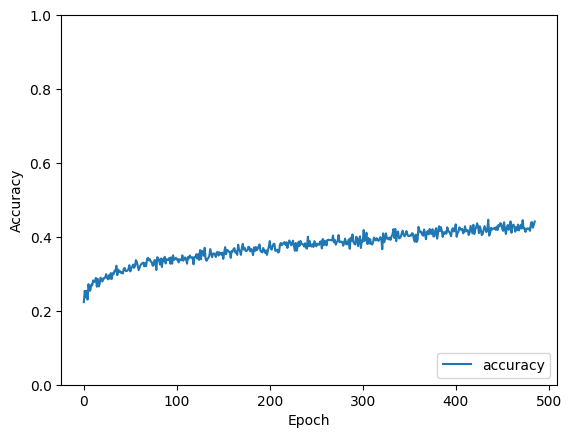

In [169]:
plt.plot(PreTrained_history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)